# Todo


- Implement LGS ✅
- Implement VSGS ✅
- Explore multiple dataset generation approach 
- Show results ✅
- Implement PSD estimation algorithm (currently the true PSD is used)
- Compare the "graph baseline" with traditional kernel methods

In [1]:
import numpy as np
import pygsp
import ruptures as rpt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from ruptures.metrics import *
from tqdm import tqdm

SEED = 6326572
np.random.seed(SEED)

In [2]:
def metrics(true_bkps, bkps, log=True):
    p, r = rpt.metrics.precision_recall(true_bkps, bkps)
    hausdorff = rpt.metrics.hausdorff(true_bkps, bkps)
    randindex = rpt.metrics.randindex(true_bkps, bkps)
    hamming = rpt.metrics.hamming(true_bkps, bkps)
    print(f"""
        Hausdorff: {hausdorff:.2f}, 
        Precision: {p:.2f}, 
        Recall: {r:.2f}, 
        Randindex: {randindex:.2f}, 
        Hamming: {hamming:.2f}
    """)
    return p, r, hausdorff, randindex

# Dataset

4 changes points


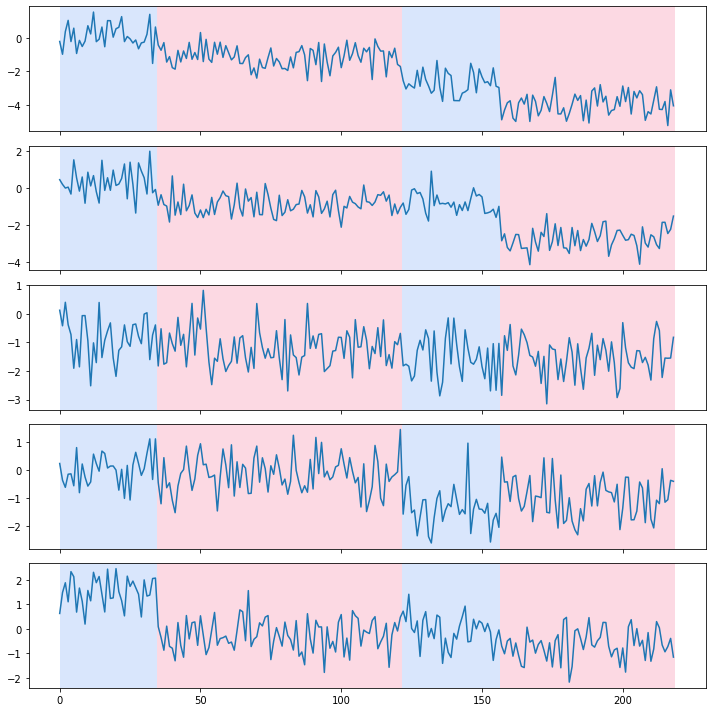

In [3]:
# Params
n_nodes = 500
p = 0.3
mean_exponential = 50
mean_change_points = 5
random_freq = 40

def generate_erdos_renyi(
        n_nodes,
        p,
        mean_exponential=50,
        mean_change_points=5,
        random_freq=20
    ):
    # Generate Graph Structure
    G = pygsp.graphs.ErdosRenyi(N=n_nodes, p=p, seed=SEED)
    G.set_coordinates()
    G.compute_fourier_basis()

    spectral_profile = lambda x: np.sqrt(15)/(np.log(x+10)+1)
    H = pygsp.filters.Filter(G, lambda x: spectral_profile(x))
    PSD = (spectral_profile(G.e))**2

    # Generate Signals
    n_bkps = np.random.poisson(lam=mean_change_points)
    bkps = []
    mus = []
    signals = []
    
    acc_bkp = 0
    acc_mean = np.zeros((n_nodes,1))
    for bkpt in range(n_bkps):
        # Get new segment mean
        subset_freq = np.random.choice(range(n_nodes), size=random_freq, replace=False)
        acc_mean[subset_freq] = np.random.uniform(-5.0,5.0,size=(random_freq,1))

        # Generate segment
        segment_length = int(np.random.exponential(scale=mean_exponential)+30)
        acc_bkp += segment_length
        signal = np.random.normal(size=(n_nodes,segment_length))
        signal = H.filter(signal) + G.igft(acc_mean)
        # Record bkp position, mean and signal
        bkps.append(acc_bkp)
        mus.append(np.copy(acc_mean))
        signals.append(signal)
    signal = np.concatenate(signals, 1)
    return G, PSD, bkps, mus, signal
    
G, PSD, true_bkps, mus, signal = generate_erdos_renyi(n_nodes,p,mean_exponential,mean_change_points,random_freq)
print(f'{len(true_bkps)} changes points')
rpt.display(signal[:5].T, true_bkps)
plt.show()

# LGS

In [4]:
class CostFunctionLGS(rpt.base.BaseCost):
    model = "lgs"
    min_size = 2
    def __init__(self, psd, lbd):
        self.lbd = lbd
        self.signal = None
        self.psd = psd
        
    def fit(self, signal):
        self.signal = signal
        return self
        
    def error(self, start, end):
        y_tilda_bar = np.mean(self.signal[start:end],axis=0)
        temp = np.abs(y_tilda_bar) - 0.5*self.lbd*self.psd
        mu_tilda_bar = np.sign(y_tilda_bar) * np.maximum(temp,0)
        
        sub_sig = np.square(self.signal[start:end] - mu_tilda_bar) / self.psd
        sub_sig += self.lbd * np.abs(mu_tilda_bar)
        
        return np.sum(sub_sig)

def fullCostLGS(cost_fct, bkps, d, T, c1, c2):
    temp = sum([cost_fct.error(bkps[k-1],bkps[k]) for k in range(1,len(bkps))])
    temp += d * (c1 + c2 * np.log(T/d))
    return temp
    
def LGS(G, signal, PSD, d_max=75, lbd=1.):
    GFT = signal @ G.U
    PSD = PSD
    cost = CostFunctionLGS(PSD, lbd).fit(GFT)
    algo = rpt.Dynp(custom_cost=cost).fit(GFT)
    best_cost = float('inf')
    best_bkps = None
    for d in tqdm(range(1,d_max+1)):
        bkps = algo.predict(n_bkps=d)
        curr_cost = fullCostLGS(cost, [0, *bkps], d, len(GFT), 500., 100.)
        if curr_cost < best_cost:
            best_cost = curr_cost
            best_bkps = bkps
    return best_bkps

100%|██████████| 40/40 [00:00<00:00, 127.36it/s]


4 changes points

        Hausdorff: 3.00, 
        Precision: 1.00, 
        Recall: 1.00, 
        Randindex: 0.97, 
        Hamming: 0.03
    


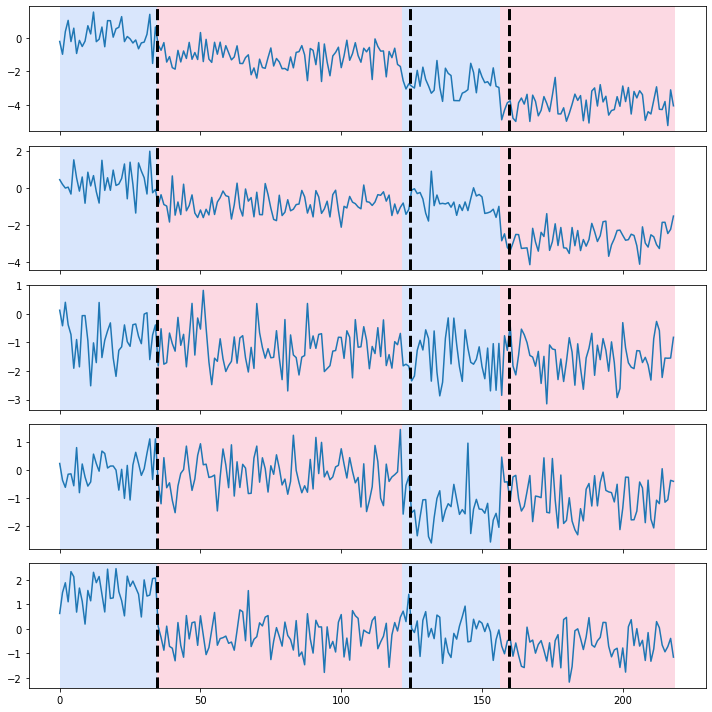

In [5]:
T = signal.shape[1]
d_max = int(T/np.log(T))
bkps = LGS(G, signal.T, PSD, d_max=d_max, lbd=10.)
print(f'{len(bkps)} changes points')
metrics(true_bkps, bkps)
rpt.display(signal[:5].T, true_bkps, bkps)
plt.show()

# VSGS

In [6]:
def lassoVSGS(signal, PSD, lbd):
    """
    Solves the lasso problem from Algorithm2 VSGS
    Solution is computed via a closed form
    """
    emp_mean = np.mean(signal, axis=0)
    temp = np.abs(emp_mean) - 0.5*lbd*PSD
    mu = np.sign(emp_mean) * np.maximum(temp,0)
    return mu

class CostFunctionVSGS(rpt.base.BaseCost):
    model = "vsgs"
    min_size = 2
    def __init__(self, psd, filter_mask):
        self.signal = None
        self.filter_mask = filter_mask
        self.psd = psd
        
    def fit(self, signal):
        self.signal = signal
        return self
        
    def error(self, start, end):
        emp_mean = np.mean(self.signal[start:end],axis=0)
        emp_mean *= self.filter_mask
        temp = np.square(self.signal[start:end] - emp_mean) / self.psd
        return np.sum(temp)

def fullCost(cost_fct, bkps):
    cost = sum([cost_fct.error(bkps[k-1],bkps[k]) for k in range(1,len(bkps))])
    return cost
    
def slopeHeuristic(parameters, T):
    X = np.zeros((len(parameters), 3))
    X[:,0] = parameters[:,2]
    X[:,1] = parameters[:,1]
    X[:,2] = parameters[:,1] * np.log(T / parameters[:,1])
    X /= T
    y = parameters[:,3] / T
    constants = - 2 * LinearRegression().fit(X, y).coef_
    return constants.tolist()

def VSGS(G, signal, PSD, lambda_set, d_max=75):
    GFT = signal @ G.U
    PSD = PSD
    T = len(signal)
    parameters_list = np.zeros((len(lambda_set)*d_max, 4)) # Array storing lbd, Dm, d, cost for each iteration
    bkps_list = [] # List storing bkps for each set of parameters
    count = 0
    for lbd in tqdm(lambda_set):
        mu = lassoVSGS(GFT, PSD, lbd)
        filter_freq = np.nonzero(np.abs(mu))[0] # Frequencies kept by Lasso
        filter_mask = (np.abs(mu) > 0) * 1. # Mask = 1 when a frequency is kept
        D_m = int(len(filter_freq)) # Number of kept frequencies
        cost = CostFunctionVSGS(PSD, filter_mask).fit(GFT)
        algo = rpt.Dynp(custom_cost=cost).fit(GFT)
        for d in range(1, d_max+1):
            bkps = algo.predict(n_bkps=d)
            curr_cost = fullCost(cost, [0, *bkps])
            bkps_list.append(bkps)
            parameters_list[count] = [lbd, d, D_m, curr_cost]
            count += 1
    K1, K2, K3 = slopeHeuristic(parameters_list, T)
    # Compute full costs with penalty + constants
    final_costs = parameters_list[:,3]
    final_costs += K1 * parameters_list[:,2]
    final_costs += K2 * parameters_list[:,1]
    final_costs += K3 * parameters_list[:,1] * np.log(T / parameters_list[:,1])

    plt.plot(final_costs)
    best_params_idx = np.argmin(final_costs)
    return bkps_list[best_params_idx]

100%|██████████| 10/10 [00:01<00:00,  5.04it/s]


4 changes points

        Hausdorff: 2.00, 
        Precision: 1.00, 
        Recall: 1.00, 
        Randindex: 0.98, 
        Hamming: 0.02
    


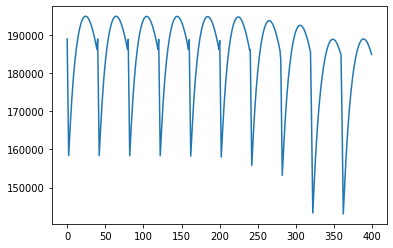

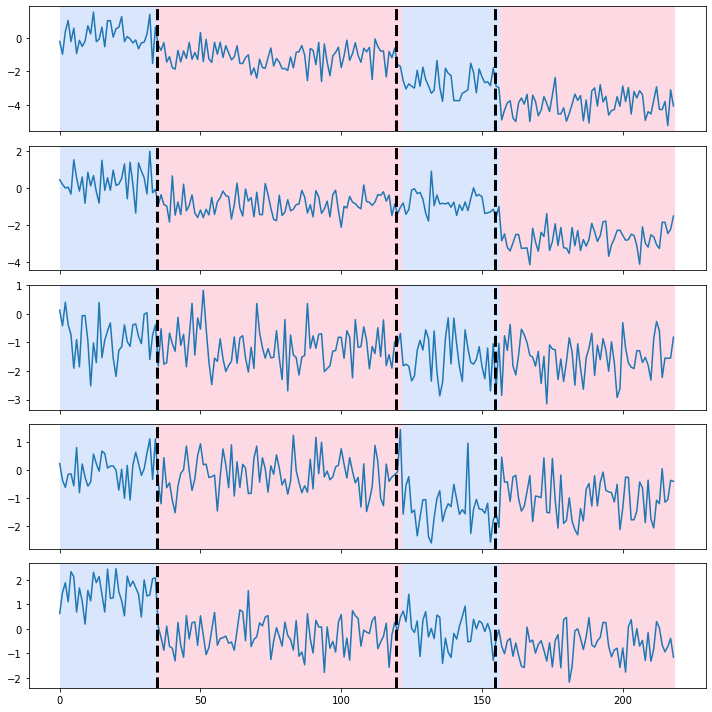

In [7]:
lambda_set = [0,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.]
T = signal.shape[1]
d_max = int(T/np.log(T))
bkps = VSGS(G, signal.T, PSD, lambda_set, d_max=d_max)
print(f'{len(bkps)} changes points')
metrics(true_bkps, bkps)
rpt.display(signal[:5].T, true_bkps, bkps)
plt.show()